Based on: https://github.com/t-davidson/hate-speech-and-offensive-language/blob/master/src/Automated%20Hate%20Speech%20Detection%20and%20the%20Problem%20of%20Offensive%20Language.ipynb

# Dependencies

In [2]:
!pip3 install vaderSentiment textstat
!pip3 install seaborn
import pandas as pd
import numpy as np
import pickle
import sys
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.stem.porter import *
import string
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as VS
from textstat.textstat import *
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
You should consider upgrading via the '/opt/homebrew/opt/python@3.9/bin/python3.9 -m pip install --upgrade pip' command.
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
     |████████████████████████████████| 292 kB 886 kB/s            
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
You should consider upgrading v

# Importing labeled dataset

In [65]:
labeled_comments = pd.read_csv('data/labeled_comments.csv', sep=';')
labeled_comments = labeled_comments[labeled_comments['label'] != -1]
labeled_comments

,comment_id,content,likes,dislikes,votes,avg,std,label,char-qty,word-qty,legibility-index
0,1489,MUITO MAIS LEGAL RRSRSRRSRSRS,2.0,0.0,4,0.000000,0.000000,0,30,5,223.62
1,273,Canhão de guerra.,2.0,4.0,3,1.000000,0.000000,1,18,4,190.91
2,2574,femi o que?,10.0,11.0,3,1.000000,0.000000,1,11,3,217.59
3,951,Concordo plenamente Jaqueline!! Outro dia ouvi...,20.0,0.0,3,0.666667,0.577350,1,161,27,228.87
4,2520,Feminista é uma mulher encalhada que precisa d...,11.0,11.0,4,1.000000,0.000000,1,66,11,226.84
...,...,...,...,...,...,...,...,...,...,...,...
3583,55,Brigue esquisitinha,0.0,1.0,3,0.666667,0.577350,1,19,2,204.50
3584,3858,"Pois é, todo o bozopata é assim! Depois que pe...",3.0,0.0,4,0.250000,0.500000,0,192,35,228.41
3585,3984,Será que ninguém tem coragem de enfrentar algu...,0.0,0.0,4,0.000000,0.000000,0,368,60,230.27
3586,790,Perfeito!,2.0,2.0,5,0.400000,0.547723,0,9,1,163.22


<div class="alert alert-info">
    <b>Dataset fields description</b>
    <hline/>
    <p><b>comment_id</b>: unique identifier to each comment from database</p>
    <p><b>content</b>: comment text content</p>
    <p><b>likes</b>: comment likes quantity</p>
    <p><b>dislikes</b>: comment dislikes quantity</p>
    <p><b>votes</b>: number of users that labeled the comment</p>
    <p><b>avg</b>: average of each vote value to the comment</p>
    <p><b>std</b>: standard deviation of each vote value to the comment</p>
    <p><b>label</b>: final label assigned to the comment, label 1 represents sexist comments and label 0 represets not sexist comments</p>
    <p><b>char-qty</b>: number of characters in the comment </p>
    <p><b>word-qty</b>: number of words in the comment</p>
    <p><b>legibility-index</b>: value of FleshBr legibility index to this comment</p>
</div>

In [66]:
labeled_comments.describe()

,comment_id,likes,dislikes,votes,avg,std,label,char-qty,word-qty,legibility-index
count,3533.000000,3287.000000,3287.000000,3533.000000,3533.000000,3533.000000,3533.000000,3533.000000,3533.000000,3533.000000
mean,1934.606850,15.720110,9.899605,3.350977,0.525278,0.271735,0.515426,138.527031,24.275403,223.161336
std,1141.239782,40.303846,42.000177,0.652721,0.379685,0.278408,0.499833,136.155936,23.547024,15.694895
min,4.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,2.000000,1.000000,-5.300000
25%,993.000000,2.000000,0.000000,3.000000,0.250000,0.000000,0.000000,47.000000,9.000000,223.620000
50%,1899.000000,5.000000,1.000000,3.000000,0.600000,0.000000,1.000000,94.000000,17.000000,228.290000
75%,2794.000000,14.000000,6.000000,4.000000,1.000000,0.577350,1.000000,179.000000,32.000000,229.810000
max,4283.000000,729.000000,1196.000000,9.000000,1.000000,0.577350,1.000000,958.000000,176.000000,230.300000


<AxesSubplot:>

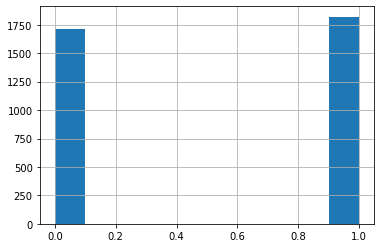

In [67]:
labeled_comments['label'].hist()

In [68]:
df = labeled_comments

# Feature generation

In [69]:
stopwords=stopwords = nltk.corpus.stopwords.words("portuguese")

other_exclusions = ["#ff", "ff", "rt"]
stopwords.extend(other_exclusions)

stemmer = PorterStemmer()


def preprocess(text_string):
    """
    Accepts a text string and replaces:
    1) urls with URLHERE
    2) lots of whitespace with one instance
    3) mentions with MENTIONHERE

    This allows us to get standardized counts of urls and mentions
    Without caring about specific people mentioned
    """
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, '', parsed_text)
    parsed_text = re.sub(mention_regex, '', parsed_text)
    return parsed_text

def tokenize(tweet):
    """Removes punctuation & excess whitespace, sets to lowercase,
    and stems tweets. Returns a list of stemmed tokens."""
    # tweet = " ".join(re.split("[^a-zA-Z]*", tweet.lower())).strip()
    tweet = ' '.join(tweet.lower().strip().split(' '))
    tokens = [stemmer.stem(t) for t in tweet.split()]
    return tokens

def basic_tokenize(tweet):
    """Same as tokenize but without the stemming"""
    # tweet = " ".join(re.split("[^a-zA-Z.,!?]*", tweet.lower())).strip()
    tweet = ' '.join(tweet.lower().strip().split(' '))
    return tweet.split()

vectorizer = TfidfVectorizer(
    tokenizer=tokenize,
    preprocessor=preprocess,
    ngram_range=(1, 3),
    stop_words=stopwords,
    use_idf=True,
    smooth_idf=False,
    norm=None,
    decode_error='replace',
    max_features=10000,
    min_df=5,
    max_df=0.75
    )

In [70]:
comments = df.content

In [71]:
#Construct tfidf matrix and get relevant scores
tfidf = vectorizer.fit_transform(comments).toarray()
vocab = {v:i for i, v in enumerate(vectorizer.get_feature_names())}
idf_vals = vectorizer.idf_
idf_dict = {i:idf_vals[i] for i in vocab.values()} #keys are indices; values are IDF scores

/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aquel', 'depoi', 'entr', 'ess', 'est', 'estamo', 'estejamo', 'estev', 'estiv', 'estivemo', 'estivermo', 'estivess', 'estivéramo', 'estivéssemo', 'estávamo', 'fomo', 'formo', 'foss', 'fôramo', 'fôssemo', 'hajamo', 'havemo', 'houv', 'houvemo', 'houveremo', 'houvermo', 'houveríamo', 'houvess', 'houvéramo', 'houvéssemo', 'ma', 'mai', 'nó', 'sejamo', 'seremo', 'seríamo', 'somo', 'temo', 'tenhamo', 'teremo', 'teríamo', 'tivemo', 'tivermo', 'tivess', 'tivéramo', 'tivéssemo', 'tínhamo', 'vo', 'éramo'] not in stop_words.
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, ca

In [72]:
nltk.download('averaged_perceptron_tagger')
#Get POS tags for comments and save as a string
comment_tags = []
for t in comments:
    tokens = basic_tokenize(preprocess(t))
    tags = nltk.pos_tag(tokens)
    tag_list = [x[1] for x in tags]
    tag_str = " ".join(tag_list)
    comment_tags.append(tag_str)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/luisabraga/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [73]:
#We can use the TFIDF vectorizer to get a token matrix for the POS tags
pos_vectorizer = TfidfVectorizer(
    tokenizer=None,
    lowercase=False,
    preprocessor=None,
    ngram_range=(1, 3),
    stop_words=None,
    use_idf=False,
    smooth_idf=False,
    norm=None,
    decode_error='replace',
    max_features=5000,
    min_df=5,
    max_df=0.75,
    )

In [74]:
#Construct POS TF matrix and get vocab dict
pos = pos_vectorizer.fit_transform(pd.Series(comment_tags)).toarray()
pos_vocab = {v:i for i, v in enumerate(pos_vectorizer.get_feature_names())}

In [75]:
#Now get other features
sentiment_analyzer = VS()

def count_twitter_objs(text_string):
    """
    Accepts a text string and replaces:
    1) urls with URLHERE
    2) lots of whitespace with one instance
    3) mentions with MENTIONHERE
    4) hashtags with HASHTAGHERE

    This allows us to get standardized counts of urls and mentions
    Without caring about specific people mentioned.
    
    Returns counts of urls, mentions, and hashtags.
    """
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    hashtag_regex = '#[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, 'URLHERE', parsed_text)
    parsed_text = re.sub(mention_regex, 'MENTIONHERE', parsed_text)
    parsed_text = re.sub(hashtag_regex, 'HASHTAGHERE', parsed_text)
    return(parsed_text.count('URLHERE'),parsed_text.count('MENTIONHERE'),parsed_text.count('HASHTAGHERE'))

def other_features(tweet):
    """This function takes a string and returns a list of features.
    These include Sentiment scores, Text and Readability scores,
    as well as Twitter specific features"""
    sentiment = sentiment_analyzer.polarity_scores(tweet)
    
    words = preprocess(tweet) #Get text only
    
    syllables = textstat.syllable_count(words)
    num_chars = sum(len(w) for w in words)
    num_chars_total = len(tweet)
    num_terms = len(tweet.split())
    num_words = len(words.split())
    avg_syl = round(float((syllables+0.001))/float(num_words+0.001),4)
    num_unique_terms = len(set(words.split()))
    
    ###Modified FK grade, where avg words per sentence is just num words/1
    FKRA = round(float(0.39 * float(num_words)/1.0) + float(11.8 * avg_syl) - 15.59,1)
    ##Modified FRE score, where sentence fixed to 1
    FRE = round(206.835 - 1.015*(float(num_words)/1.0) - (84.6*float(avg_syl)),2)
    
    twitter_objs = count_twitter_objs(tweet)
    retweet = 0
    if "rt" in words:
        retweet = 1
    features = [FKRA, FRE,syllables, avg_syl, num_chars, num_chars_total, num_terms, num_words,
                num_unique_terms, sentiment['neg'], sentiment['pos'], sentiment['neu'], sentiment['compound'],
                twitter_objs[2], twitter_objs[1],
                twitter_objs[0], retweet]
    #features = pandas.DataFrame(features)
    return features

def get_feature_array(tweets):
    feats=[]
    for t in tweets:
        feats.append(other_features(t))
    return np.array(feats)

In [76]:
other_features_names = ["FKRA", "FRE","num_syllables", "avg_syl_per_word", "num_chars", "num_chars_total", \
                        "num_terms", "num_words", "num_unique_words", "vader neg","vader pos","vader neu", \
                        "vader compound", "num_hashtags", "num_mentions", "num_urls", "is_retweet"]

In [77]:
feats = get_feature_array(comments)

In [78]:
#Now join them all up
M = np.concatenate([tfidf,pos,feats],axis=1)

In [79]:
#Finally get a list of variable names
variables = ['']*len(vocab)
for k,v in vocab.items():
    variables[v] = k

pos_variables = ['']*len(pos_vocab)
for k,v in pos_vocab.items():
    pos_variables[v] = k

feature_names = variables+pos_variables+other_features_names

# Running the model

In [80]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import f1_score, precision_score, recall_score

X = pd.DataFrame(M)
y = df['label'].astype(int)


for i in range(0,10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    model_svc = LinearSVC(class_weight='balanced',C=0.01, penalty='l2', loss='squared_hinge',multi_class='ovr').fit(X_train, y_train)
    model_lr = LogisticRegression(class_weight='balanced',penalty='l2',C=0.01).fit(X_train, y_train)

    y_preds_svc = model_svc.predict(X_test)
    y_preds_lr = model_lr.predict(X_test)
    print(f'------------------- {i} --------------------')
    print('SVM')
    print(classification_report(y_test,y_preds_svc))
    print('LR')
    print(classification_report(y_test,y_preds_lr))

/opt/homebrew/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


------------------- 0 --------------------
SVM
              precision    recall  f1-score   support

           0       0.57      0.63      0.60       335
           1       0.63      0.58      0.60       372

    accuracy                           0.60       707
   macro avg       0.60      0.60      0.60       707
weighted avg       0.60      0.60      0.60       707

LR
              precision    recall  f1-score   support

           0       0.60      0.66      0.63       335
           1       0.66      0.60      0.63       372

    accuracy                           0.63       707
   macro avg       0.63      0.63      0.63       707
weighted avg       0.63      0.63      0.63       707



/opt/homebrew/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


------------------- 1 --------------------
SVM
              precision    recall  f1-score   support

           0       0.57      0.65      0.60       335
           1       0.63      0.55      0.59       372

    accuracy                           0.60       707
   macro avg       0.60      0.60      0.60       707
weighted avg       0.60      0.60      0.60       707

LR
              precision    recall  f1-score   support

           0       0.60      0.66      0.63       335
           1       0.66      0.60      0.63       372

    accuracy                           0.63       707
   macro avg       0.63      0.63      0.63       707
weighted avg       0.63      0.63      0.63       707



/opt/homebrew/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


------------------- 2 --------------------
SVM
              precision    recall  f1-score   support

           0       0.57      0.62      0.59       335
           1       0.63      0.59      0.61       372

    accuracy                           0.60       707
   macro avg       0.60      0.60      0.60       707
weighted avg       0.60      0.60      0.60       707

LR
              precision    recall  f1-score   support

           0       0.60      0.66      0.63       335
           1       0.66      0.60      0.63       372

    accuracy                           0.63       707
   macro avg       0.63      0.63      0.63       707
weighted avg       0.63      0.63      0.63       707



/opt/homebrew/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


------------------- 3 --------------------
SVM
              precision    recall  f1-score   support

           0       0.56      0.65      0.60       335
           1       0.63      0.54      0.58       372

    accuracy                           0.59       707
   macro avg       0.59      0.59      0.59       707
weighted avg       0.60      0.59      0.59       707

LR
              precision    recall  f1-score   support

           0       0.60      0.66      0.63       335
           1       0.66      0.60      0.63       372

    accuracy                           0.63       707
   macro avg       0.63      0.63      0.63       707
weighted avg       0.63      0.63      0.63       707



/opt/homebrew/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


------------------- 4 --------------------
SVM
              precision    recall  f1-score   support

           0       0.56      0.69      0.62       335
           1       0.65      0.51      0.57       372

    accuracy                           0.60       707
   macro avg       0.61      0.60      0.60       707
weighted avg       0.61      0.60      0.60       707

LR
              precision    recall  f1-score   support

           0       0.60      0.66      0.63       335
           1       0.66      0.60      0.63       372

    accuracy                           0.63       707
   macro avg       0.63      0.63      0.63       707
weighted avg       0.63      0.63      0.63       707



/opt/homebrew/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


------------------- 5 --------------------
SVM
              precision    recall  f1-score   support

           0       0.57      0.63      0.60       335
           1       0.64      0.58      0.61       372

    accuracy                           0.60       707
   macro avg       0.61      0.61      0.60       707
weighted avg       0.61      0.60      0.60       707

LR
              precision    recall  f1-score   support

           0       0.60      0.66      0.63       335
           1       0.66      0.60      0.63       372

    accuracy                           0.63       707
   macro avg       0.63      0.63      0.63       707
weighted avg       0.63      0.63      0.63       707



/opt/homebrew/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


------------------- 6 --------------------
SVM
              precision    recall  f1-score   support

           0       0.57      0.59      0.58       335
           1       0.62      0.59      0.60       372

    accuracy                           0.59       707
   macro avg       0.59      0.59      0.59       707
weighted avg       0.59      0.59      0.59       707

LR
              precision    recall  f1-score   support

           0       0.60      0.66      0.63       335
           1       0.66      0.60      0.63       372

    accuracy                           0.63       707
   macro avg       0.63      0.63      0.63       707
weighted avg       0.63      0.63      0.63       707



/opt/homebrew/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


------------------- 7 --------------------
SVM
              precision    recall  f1-score   support

           0       0.57      0.57      0.57       335
           1       0.61      0.61      0.61       372

    accuracy                           0.59       707
   macro avg       0.59      0.59      0.59       707
weighted avg       0.59      0.59      0.59       707

LR
              precision    recall  f1-score   support

           0       0.60      0.66      0.63       335
           1       0.66      0.60      0.63       372

    accuracy                           0.63       707
   macro avg       0.63      0.63      0.63       707
weighted avg       0.63      0.63      0.63       707



/opt/homebrew/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


------------------- 8 --------------------
SVM
              precision    recall  f1-score   support

           0       0.57      0.63      0.60       335
           1       0.63      0.58      0.60       372

    accuracy                           0.60       707
   macro avg       0.60      0.60      0.60       707
weighted avg       0.61      0.60      0.60       707

LR
              precision    recall  f1-score   support

           0       0.60      0.66      0.63       335
           1       0.66      0.60      0.63       372

    accuracy                           0.63       707
   macro avg       0.63      0.63      0.63       707
weighted avg       0.63      0.63      0.63       707



/opt/homebrew/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


------------------- 9 --------------------
SVM
              precision    recall  f1-score   support

           0       0.56      0.69      0.62       335
           1       0.65      0.52      0.57       372

    accuracy                           0.60       707
   macro avg       0.61      0.60      0.60       707
weighted avg       0.61      0.60      0.60       707

LR
              precision    recall  f1-score   support

           0       0.60      0.66      0.63       335
           1       0.66      0.60      0.63       372

    accuracy                           0.63       707
   macro avg       0.63      0.63      0.63       707
weighted avg       0.63      0.63      0.63       707



/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# Results

In [85]:
with open('data/baseline_results.txt') as fp:
    file_lines = fp.readlines()

In [86]:
svm = {
    'precision_0': [],
    'recall_0': [],
    'f1_0': [],
    'precision_1': [],
    'recall_1': [],
    'f1_1': [],
    'f1_macro': []
}

lr = {
    'precision_0': [],
    'recall_0': [],
    'f1_0': [],
    'precision_1': [],
    'recall_1': [],
    'f1_1': [],
    'f1_macro': []
}

data = []
for line in file_lines:
    is_data_line = ('----' not in line) and\
                   ('SVM' not in line) and\
                   ('LR' not in line) and\
                   ('precision' not in line) and\
                   ('\n' != line) and \
                   ('accuracy' not in line) and\
                   ('weightedavg' not in line)
    if is_data_line:
        data.append(line.replace('           ','')\
                        .replace('      ', ';')\
                        .replace(' ', '')\
                        .replace('\n', '')\
                        .split(';'))

In [87]:
for i in range(0,len(data),8):
    row = data[i:i+8]
    svm['precision_0'].append(float(row[0][1]))
    svm['recall_0'].append(float(row[0][2]))
    svm['f1_0'].append(float(row[0][3]))
    svm['precision_1'].append(float(row[1][1]))
    svm['recall_1'].append(float(row[1][2]))
    svm['f1_1'].append(float(row[1][3]))
    svm['f1_macro'].append(float(row[2][3]))
    lr['f1_macro'].append(float(row[6][3]))
    lr['precision_0'].append(float(row[4][1]))
    lr['recall_0'].append(float(row[4][2]))
    lr['f1_0'].append(float(row[4][3]))
    lr['precision_1'].append(float(row[5][1]))
    lr['recall_1'].append(float(row[5][2]))
    lr['f1_1'].append(float(row[5][3]))

In [88]:
svm

{'precision_0': [0.57, 0.57, 0.57, 0.56, 0.56, 0.57, 0.57, 0.57, 0.57, 0.56],
 'recall_0': [0.63, 0.65, 0.62, 0.65, 0.69, 0.63, 0.59, 0.57, 0.63, 0.69],
 'f1_0': [0.6, 0.6, 0.59, 0.6, 0.62, 0.6, 0.58, 0.57, 0.6, 0.62],
 'precision_1': [0.63, 0.63, 0.63, 0.63, 0.65, 0.64, 0.62, 0.61, 0.63, 0.65],
 'recall_1': [0.58, 0.55, 0.59, 0.54, 0.51, 0.58, 0.59, 0.61, 0.58, 0.52],
 'f1_1': [0.6, 0.59, 0.61, 0.58, 0.57, 0.61, 0.6, 0.61, 0.6, 0.57],
 'f1_macro': [0.6, 0.6, 0.6, 0.59, 0.6, 0.6, 0.59, 0.59, 0.6, 0.6]}